# ENSF 592 - FINAL PROJECT
## Calgary Incident Analysis
### By: Mike Lasby

# README
This notebook is the entry point of our project and functions as the View. The notebook depends on the Controller.py class to retrieve views of our data from the Model. Please see the enclosed pdf report for a discussion of the data analysis below. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from geojson import Point, MultiLineString
import geopandas as gpdnum_points
import re
import math
from folium_0_12 import folium #using pre released v0.12 due to heatmap issues 
# NOTE:  https://github.com/python-visualization/folium/issues/1271
import matplotlib.pyplot as plt
from controller import Controller

In [2]:
ctrl = Controller()
ctrl.load_data()
ctrl.add_geo_cols()
ctrl.add_cell_col()
ctrl.get_cell_data()
ctrl.generate_maps()

Loading Data...
Getting weather at yyc for month 1 in 2018
Getting weather at yyc for month 2 in 2018
Getting weather at yyc for month 3 in 2018
Getting weather at yyc for month 4 in 2018
Getting weather at yyc for month 5 in 2018
Getting weather at yyc for month 6 in 2018
Getting weather at yyc for month 7 in 2018
Getting weather at yyc for month 8 in 2018
Getting weather at yyc for month 9 in 2018
Getting weather at yyc for month 10 in 2018
Getting weather at yyc for month 11 in 2018
Getting weather at yyc for month 12 in 2018
...Data Loaded.
Adding geometry column to speeds from multiline. Flip coords? True
Adding geometry column to volumes from multilinestring. Flip coords? True
Adding geometry column to incidents from location. Flip coords? False
Adding geometry column to cameras from None. Flip coords? True
Adding geometry column to signals from Point. Flip coords? True
Adding geometry column to signs from POINT. Flip coords? True
Adding geometry column to cells from cell_bounds.

In [3]:
cells = ctrl.get_frame('cells')
display(cells.sort_values(by='avg_speed', ascending = False).head())
display(cells.sort_values(by='volume_sum', ascending = False).head())

cell_bounds  avg_speed  volume_sum  \
60  [[51.0645838, -114.315796], [51.1015441, -114....     110.00     44000.0   
88  [[51.1385044, -113.9510832], [51.1754647000000...      86.88    124000.0   
7   [[50.842822, -113.9966723], [50.8797823, -113....      82.53    140000.0   
96  [[51.175464700000006, -114.0422614], [51.21242...      80.09    167000.0   
59  [[51.027623500000004, -113.9054941], [51.06458...      80.00     16000.0   

    incident_count  sign_count  signal_count  camera_count     signal_bins  \
60               5         116             0             0  (-0.223, 22.3]   
88              26         346             3             0  (-0.223, 22.3]   
7               13         756             7             0  (-0.223, 22.3]   
96              22          52             0             0  (-0.223, 22.3]   
59               5         118             1             0  (-0.223, 22.3]   

            sign_bins       speed_bins          volume_bins  inc_per_mil_vol  \
60  (-33.465, 3346.5]  (103.31, 110.0]  (-1800.0, 382000.0]       113.636364   
88  (-33.465, 3346.5]   (83.24, 89.93]  (-1800.0, 382000.0]       209.677419   
7   (-33.465, 3346.5]   (76.55, 83.24]  (-1800.0, 382000.0]        92.857143   
96  (-33.465, 3346.5]   (76.55, 83.24]  (-1800.0, 382000.0]       131.736527   
59  (-33.465, 3346.5]   (76.55, 83.24]  (-1800.0, 382000.0]       312.500000   

    x_coord  y_coord                                              cells  \
60        0        6  <folium.vector_layers.Rectangle object at 0x7f...   
88        8        8  <folium.vector_layers.Rectangle object at 0x7f...   
7         7        0  <folium.vector_layers.Rectangle object at 0x7f...   
96        6        9  <folium.vector_layers.Rectangle object at 0x7f...   
59        9        5  <folium.vector_layers.Rectangle object at 0x7f...   

                                            vol_cells  \
60  <folium.vector_layers.Rectangle object at 0x7f...   
88  <folium.vector_layers.Rectangle object at 0x7f...   
7   <folium.vector_layers.Rectangle object at 0x7f...   
96  <folium.vector_layers.Rectangle object at 0x7f...   
59  <folium.vector_layers.Rectangle object at 0x7f...   

                                          speed_cells  
60  <folium.vector_layers.Rectangle object at 0x7f...  
88  <folium.vector_layers.Rectangle object at 0x7f...  
7   <folium.vector_layers.Rectangle object at 0x7f...  
96  <folium.vector_layers.Rectangle object at 0x7f...  
59  <folium.vector_layers.Rectangle object at 0x7f...

cell_bounds  avg_speed  volume_sum  \
55  [[51.027623500000004, -114.0878505], [51.06458...      44.58   3802000.0   
66  [[51.0645838, -114.0422614], [51.1015441, -113...      67.48   2002000.0   
54  [[51.027623500000004, -114.1334396], [51.06458...      55.91   1834000.0   
56  [[51.027623500000004, -114.0422614], [51.06458...      70.07   1452000.0   
45  [[50.9906632, -114.0878505], [51.0276235000000...      58.09   1451000.0   

    incident_count  sign_count  signal_count  camera_count     signal_bins  \
55             465       33465           223            22  (200.7, 223.0]   
66             354        2475            36             6    (22.3, 44.6]   
54             326       12676            77             8    (66.9, 89.2]   
56             362        5590            38             5    (22.3, 44.6]   
45             307        7204            61             9    (44.6, 66.9]   

             sign_bins       speed_bins             volume_bins  \
55  (30118.5, 33465.0]  (43.033, 49.79]  (3422000.0, 3802000.0]   
66   (-33.465, 3346.5]   (63.17, 69.86]  (1902000.0, 2282000.0]   
54  (10039.5, 13386.0]   (49.79, 56.48]  (1522000.0, 1902000.0]   
56    (3346.5, 6693.0]   (69.86, 76.55]  (1142000.0, 1522000.0]   
45   (6693.0, 10039.5]   (56.48, 63.17]  (1142000.0, 1522000.0]   

    inc_per_mil_vol  x_coord  y_coord  \
55       122.304050        5        5   
66       176.823177        6        6   
54       177.753544        4        5   
56       249.311295        6        5   
45       211.578222        5        4   

                                                cells  \
55  <folium.vector_layers.Rectangle object at 0x7f...   
66  <folium.vector_layers.Rectangle object at 0x7f...   
54  <folium.vector_layers.Rectangle object at 0x7f...   
56  <folium.vector_layers.Rectangle object at 0x7f...   
45  <folium.vector_layers.Rectangle object at 0x7f...   

                                            vol_cells  \
55  <folium.vector_layers.Rectangle object at 0x7f...   
66  <folium.vector_layers.Rectangle object at 0x7f...   
54  <folium.vector_layers.Rectangle object at 0x7f...   
56  <folium.vector_layers.Rectangle object at 0x7f...   
45  <folium.vector_layers.Rectangle object at 0x7f...   

                                          speed_cells  
55  <folium.vector_layers.Rectangle object at 0x7f...  
66  <folium.vector_layers.Rectangle object at 0x7f...  
54  <folium.vector_layers.Rectangle object at 0x7f...  
56  <folium.vector_layers.Rectangle object at 0x7f...  
45  <folium.vector_layers.Rectangle object at 0x7f...

# Map Visualizations

## Cell Map

In [4]:
%%html
<iframe src="cell_map.html" frameborder = "0" width = "960" height = "600" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

## Average Speed Map

In [5]:
ctrl.draw_speed_map()

map saved


In [6]:
%%html
<iframe src="speed_map.html" frameborder = "0" width = "960" height = "600" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

## Traffic Volume Heatmap

In [7]:
ctrl.gen_heatmap()

map saved


In [8]:
%%html
<iframe src="volume_map.html" frameborder = "0" width = "960" height = "600" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>



# Cell Summary 

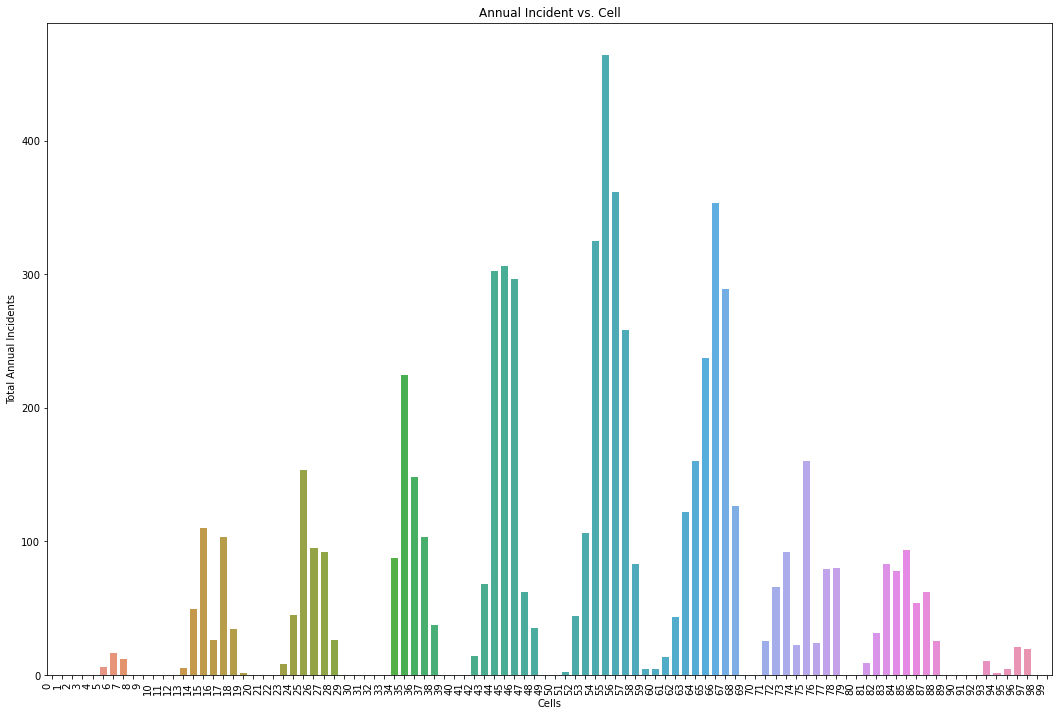

In [9]:
cells = ctrl.get_frame('cells')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18,12)) #we want to plot side by side and to that figsize
sns.set_style('whitegrid')
sns.barplot(x=cells.index, y = cells['incident_count'], data =cells)
ax.set_xlabel("Cells")
ax.set_ylabel("Total Annual Incidents")
ax.set_title('Annual Incident vs. Cell')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
fig.show()
plt.savefig('./plots/annual incident vs cell.png')


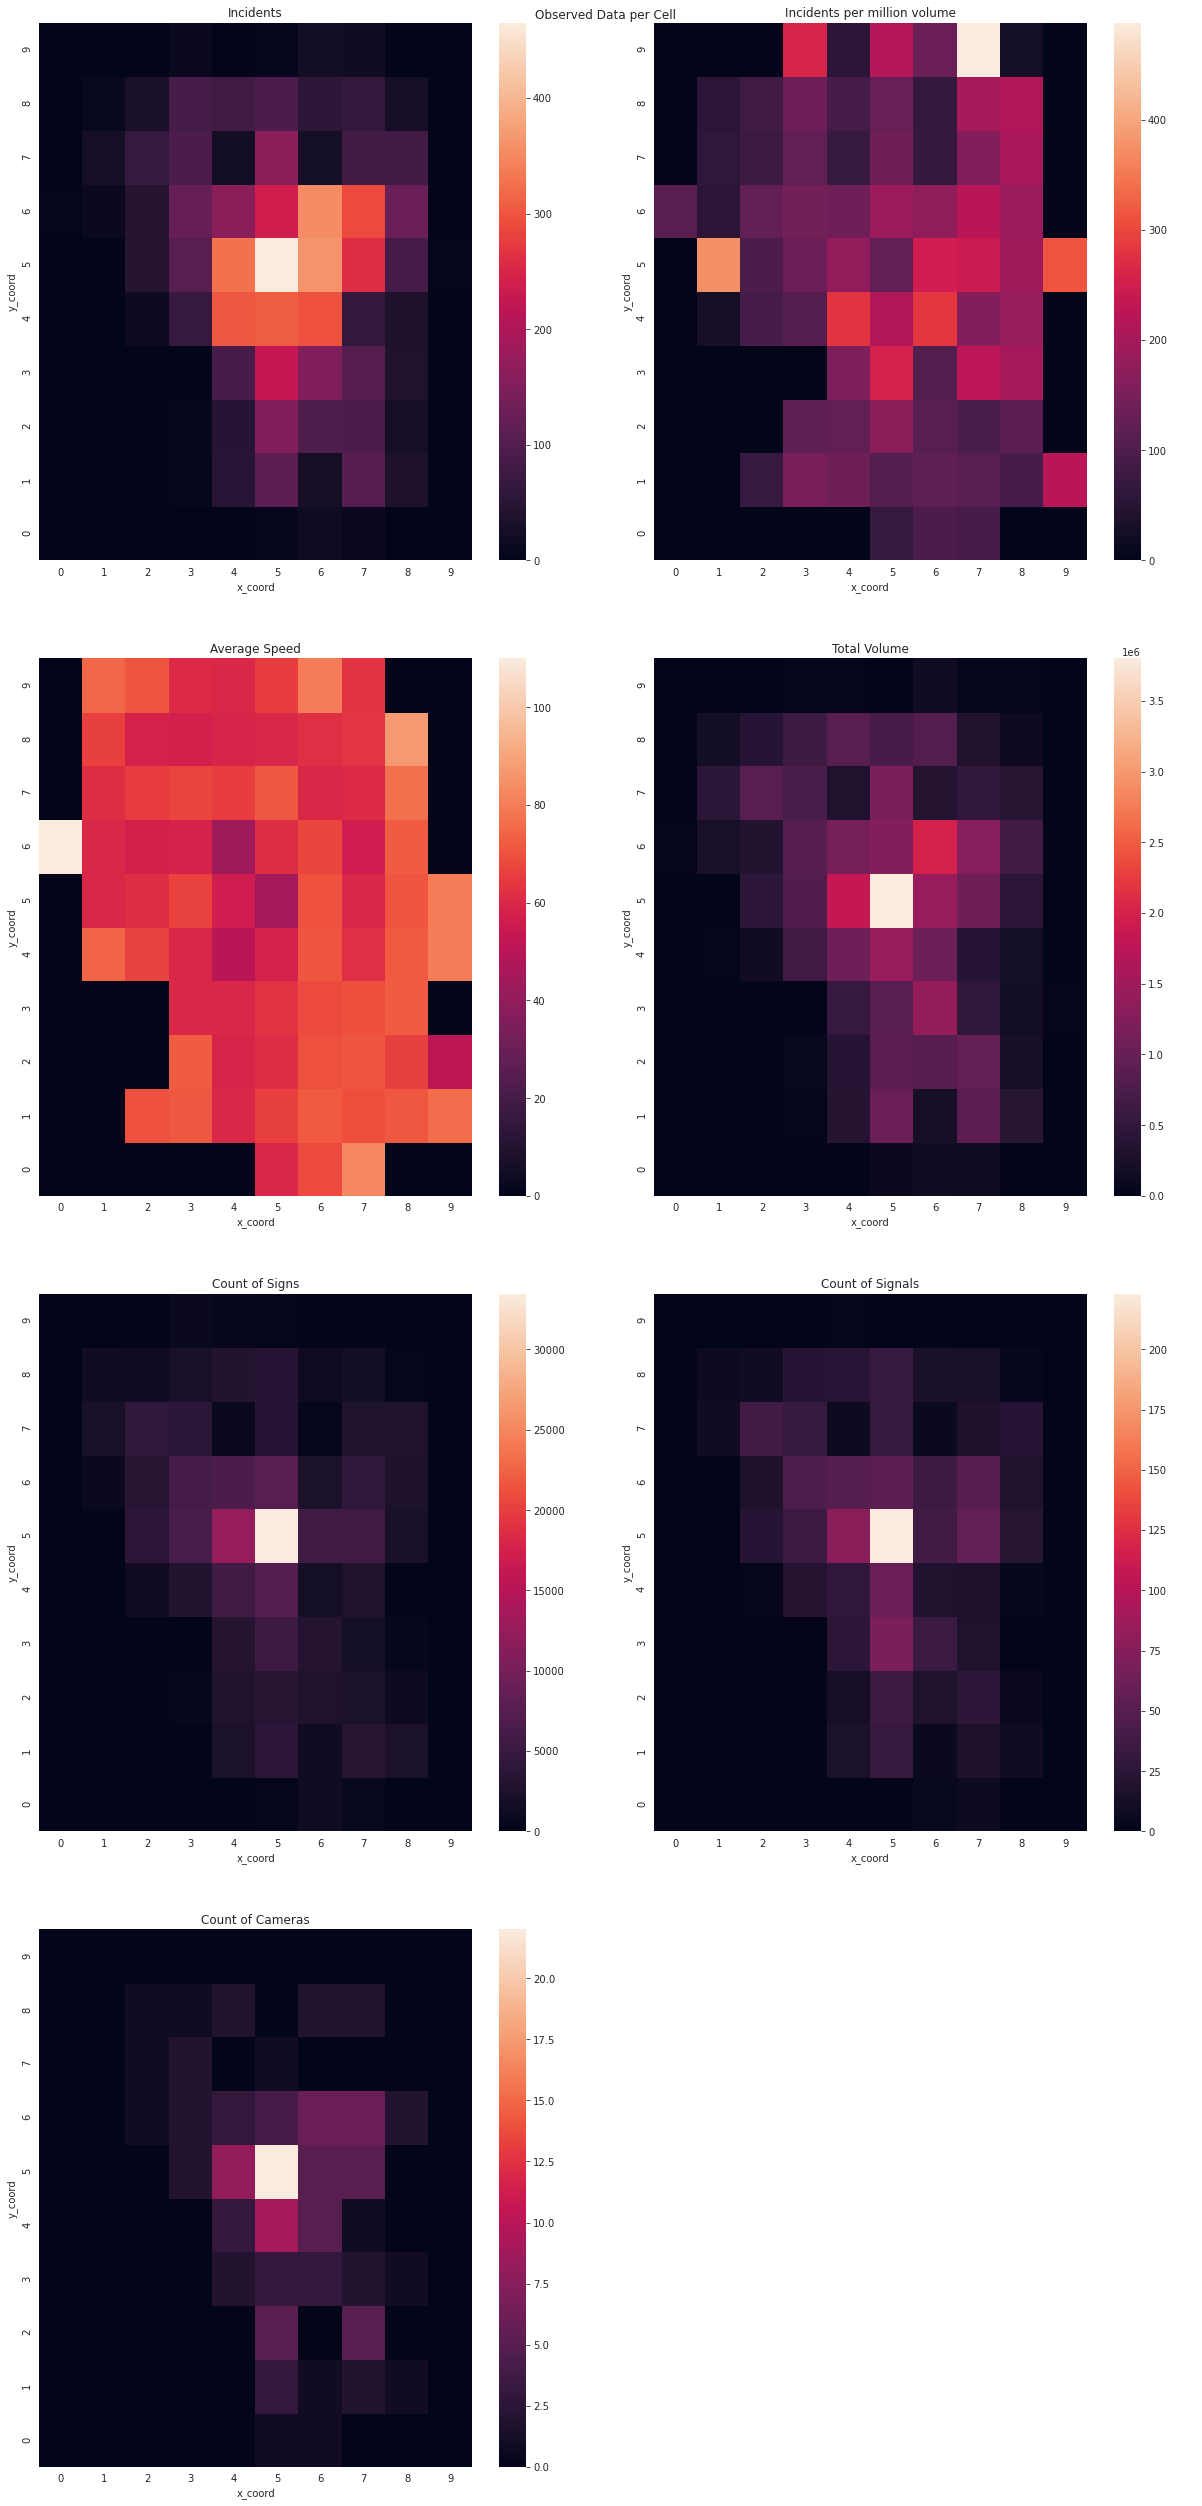

In [10]:
cells = ctrl.get_frame('cells')

fig, ( (inc_ax, inc_mil_ax), (speed_ax, vol_ax), (sign_ax, signal_ax), (camera_ax, unsued_ax) ) = plt.subplots(nrows = 4, ncols = 2, figsize=(18,36))

ctrl.cell_heatmap('cells', 'incident_count', inc_ax, 'Incidents')
ctrl.cell_heatmap('cells', 'inc_per_mil_vol', inc_mil_ax, 'Incidents per million volume')
ctrl.cell_heatmap('cells', 'avg_speed',speed_ax, 'Average Speed')
ctrl.cell_heatmap('cells', 'volume_sum', vol_ax, 'Total Volume')
ctrl.cell_heatmap('cells', 'sign_count', sign_ax, 'Count of Signs')
ctrl.cell_heatmap('cells', 'signal_count', signal_ax, 'Count of Signals')
ctrl.cell_heatmap('cells', 'camera_count',camera_ax, 'Count of Cameras')
fig.suptitle("Observed Data per Cell")
fig.tight_layout(pad=5)
unsued_ax.axis('off')
fig.show()
plt.savefig('./plots/heatmaps.png')


# Correlations

## Static Correlations

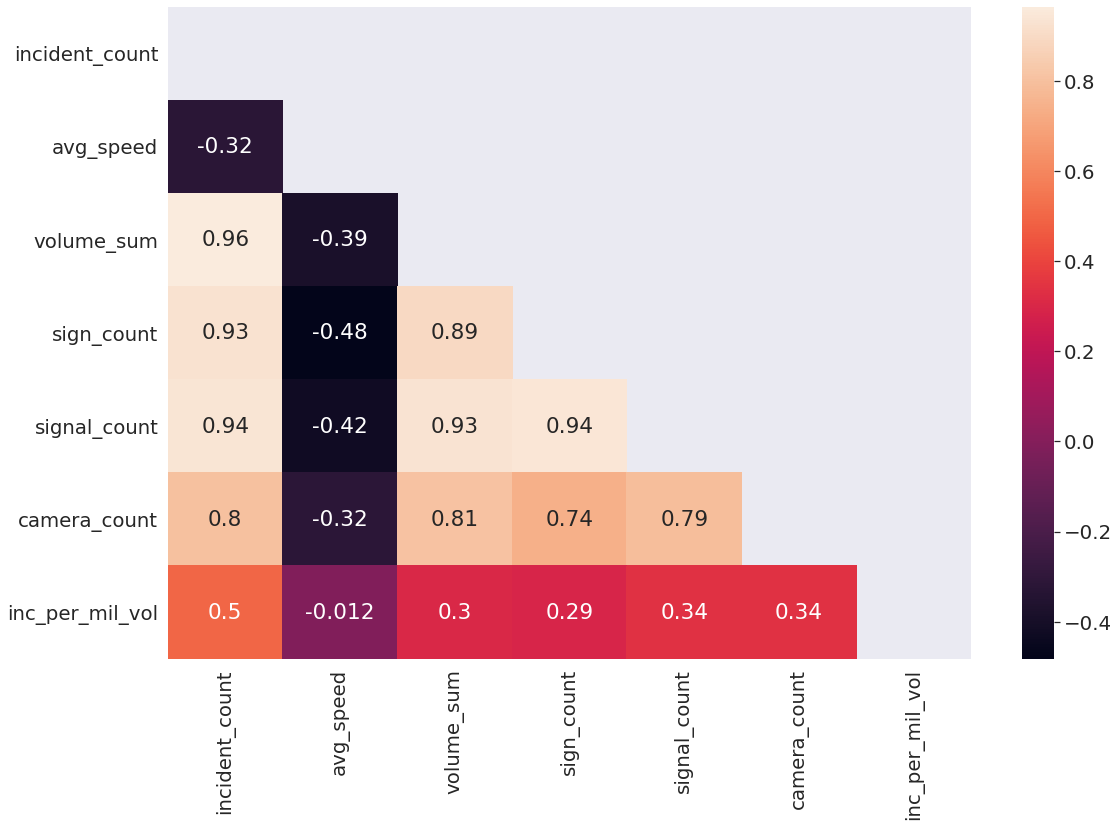

In [11]:
static_corr = ctrl.get_frame('cells')[ ['incident_count', 'avg_speed', 'volume_sum', 'sign_count', 'signal_count', 'camera_count', 'inc_per_mil_vol'] ]
static_corr = static_corr.corr(method='spearman')
# display(static_corr['incident_count'])
sns.set(font_scale=1.8)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18,12)) 

mask = np.zeros_like(static_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(static_corr, annot= True, mask=mask)
fig.show()
plt.savefig('./plots/static correlations.png')

## Time Series Correlations 

### Hourly Correlations

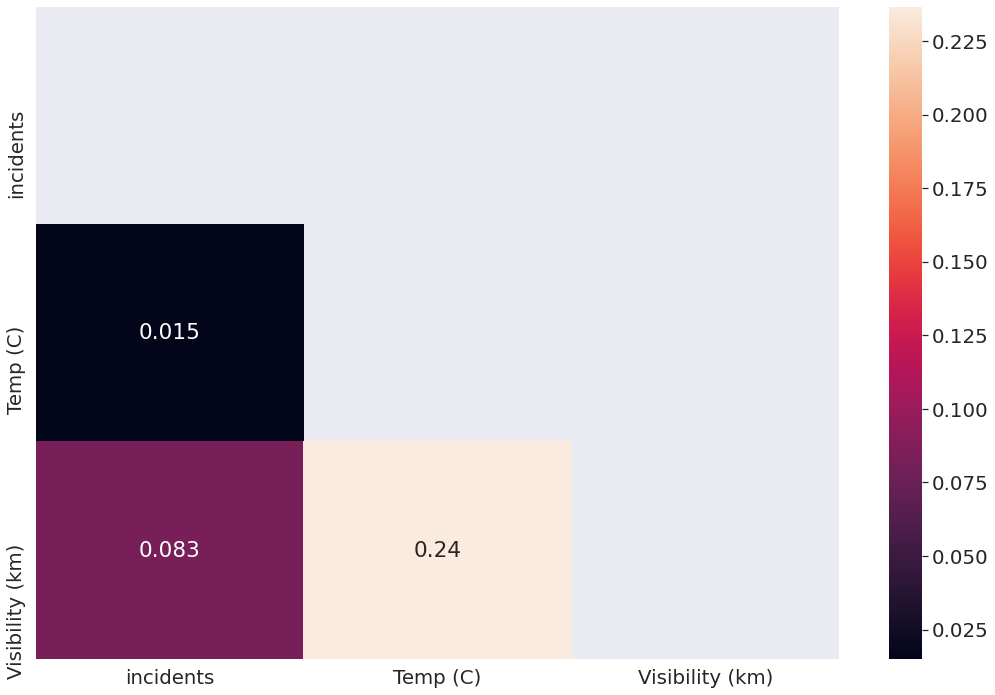

In [12]:
hourly_corr = ctrl.get_frame('hourly')[ ['incidents', 'Temp (C)', 'Visibility (km)'] ]
hourly_corr = hourly_corr.corr(method='spearman')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18,12)) 

mask = np.zeros_like(hourly_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(hourly_corr, annot= True, mask=mask)
fig.show()
plt.savefig('./plots/hourly correlations.png')

### Daily Correlations

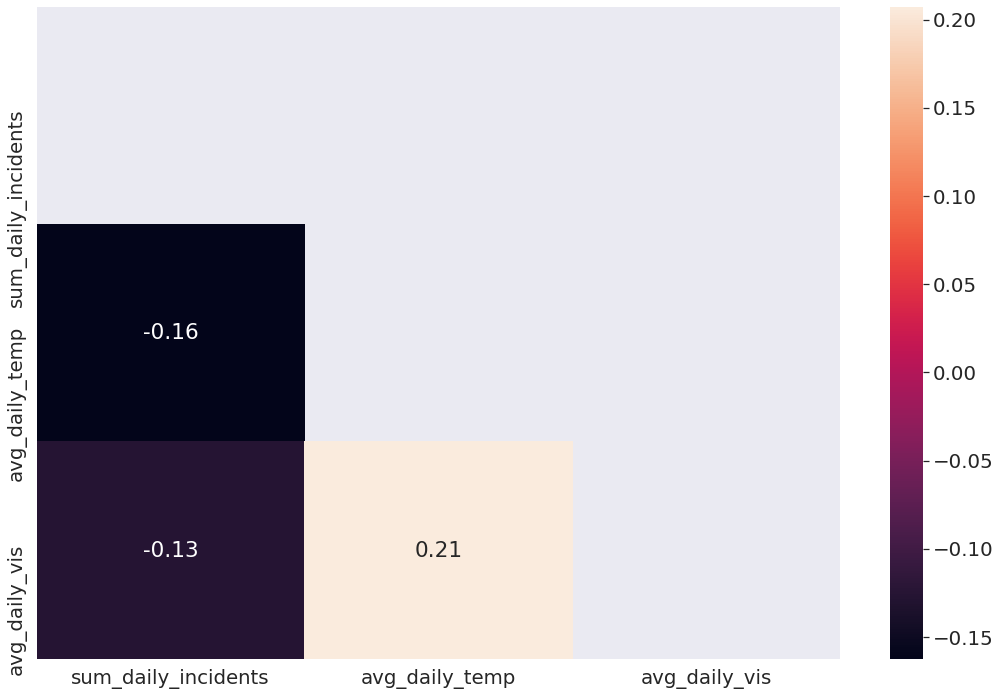

In [13]:
daily_corr = ctrl.get_frame('daily')[ ['sum_daily_incidents', 'avg_daily_temp', 'avg_daily_vis'] ]
daily_corr = daily_corr.corr(method='spearman')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18,12)) 

mask = np.zeros_like(hourly_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(daily_corr, annot= True, mask=mask)
fig.show()
plt.savefig('./plots/daily correlations.png')

# Incidents vs. Speed 

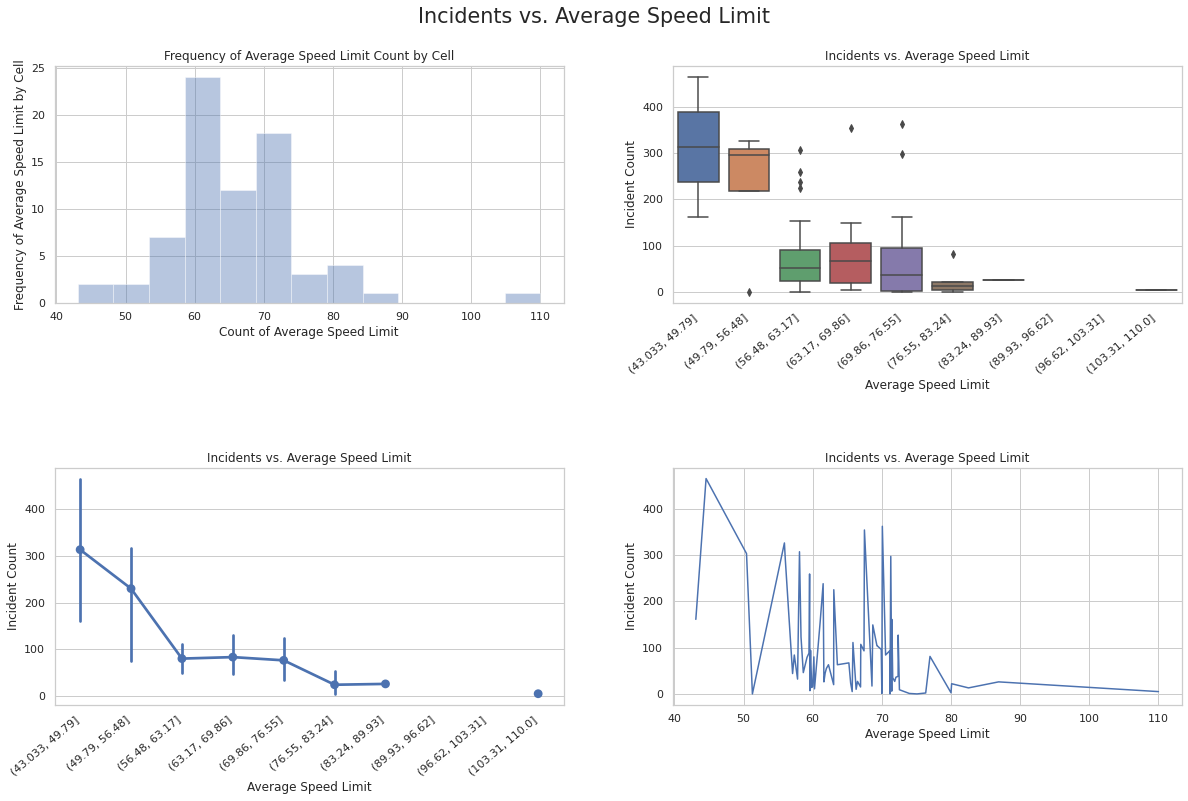

In [14]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid')
df =  ctrl.get_frame('cells')
target_text = 'Average Speed Limit'
target_col = 'avg_speed'
responding_col = 'incident_count'
x_label = 'Average Speed Limit'
y_label = 'Incident Count'
title = 'Incidents vs. Average Speed Limit'
binned = True
bin_col = 'speed_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()


# Incidents per million trips vs. Speed

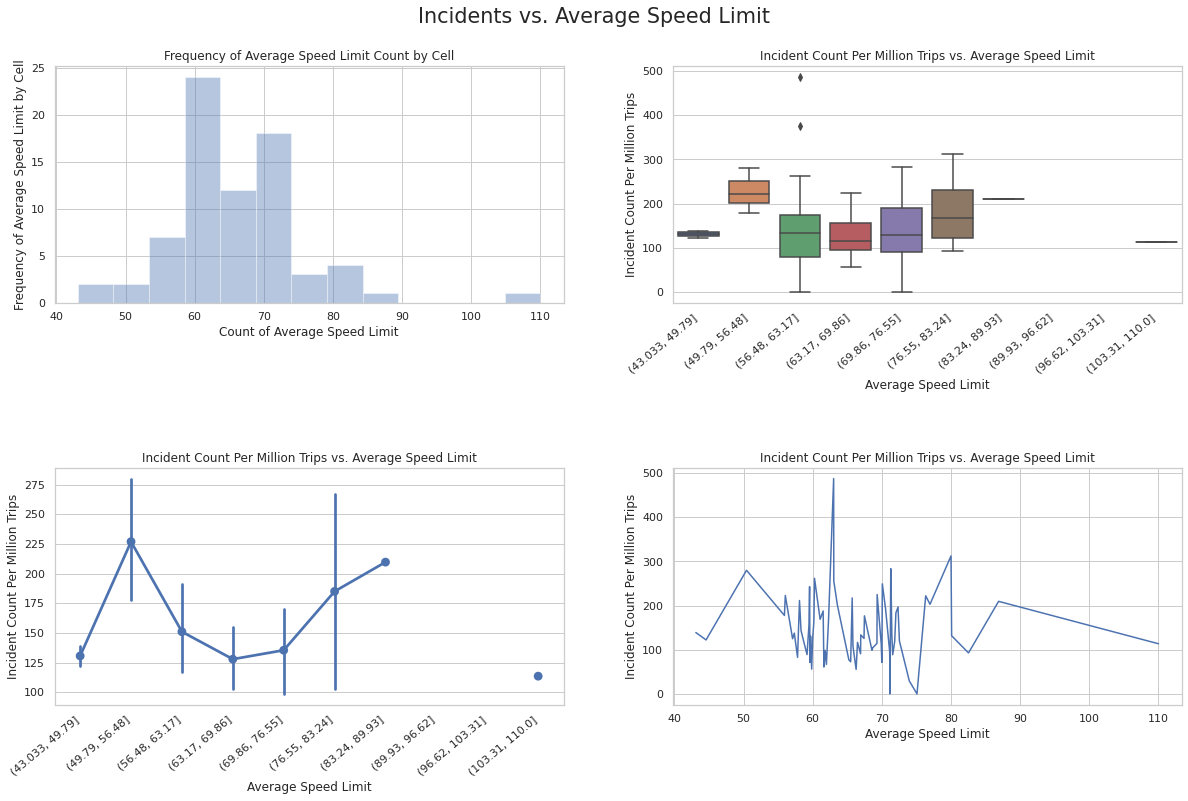

In [26]:
sns.set(font_scale=1.0)
sns.set_style('whitegrid')
df =  ctrl.get_frame('cells')
target_text = 'Average Speed Limit'
target_col = 'avg_speed'
responding_col = 'inc_per_mil_vol'
x_label = 'Average Speed Limit'
y_label = 'Incident Count Per Million Trips'
title = 'Incident Count Per Million Trips vs. Average Speed Limit'
binned = True
bin_col = 'speed_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()


# Incidents vs. Volume

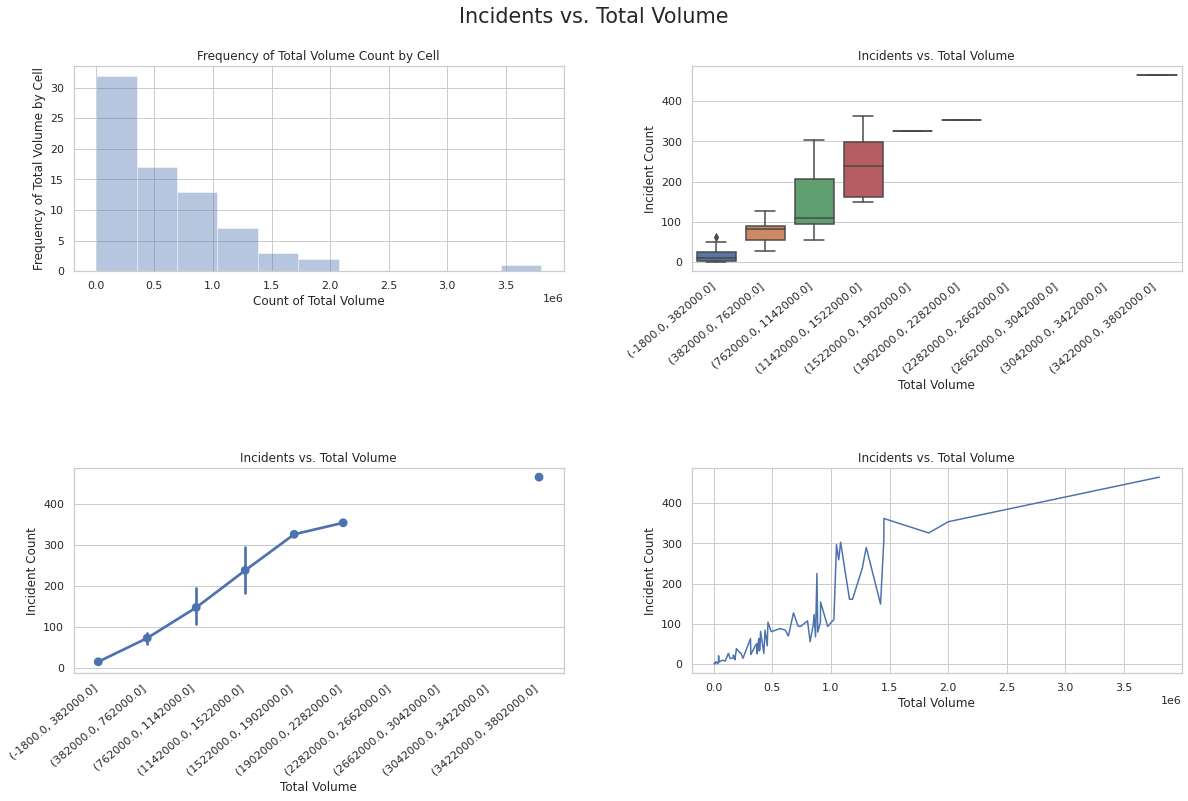

In [15]:
df =  ctrl.get_frame('cells')
target_text = 'Total Volume'
target_col = 'volume_sum'
responding_col = 'incident_count'
x_label = 'Total Volume'
y_label = 'Incident Count'
title = 'Incidents vs. Total Volume'
binned = True
bin_col = 'volume_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()


# Incidents vs. Cameras

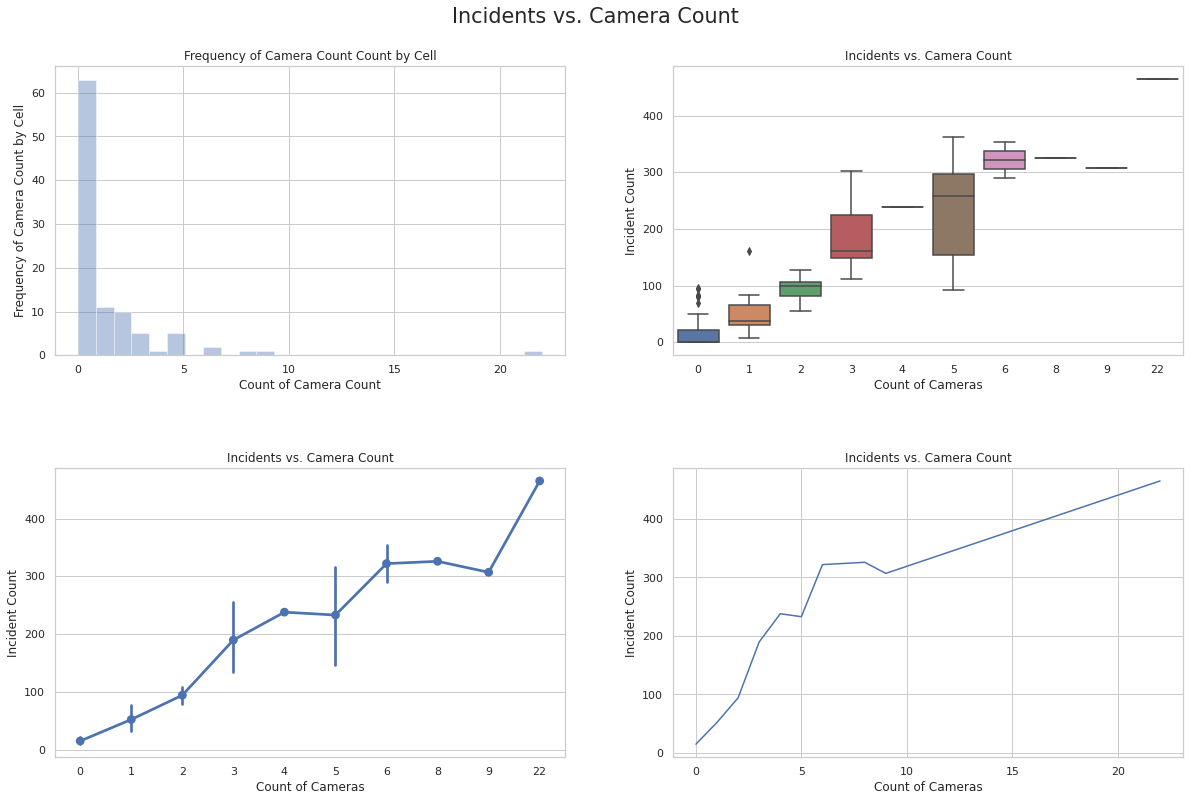

In [16]:
df =  ctrl.get_frame('cells')
target_text = 'Camera Count'
target_col = 'camera_count'
responding_col = 'incident_count'
x_label = 'Count of Cameras'
y_label = 'Incident Count'
title = 'Incidents vs. Camera Count'
binned = False

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents per million trips vs. Cameras

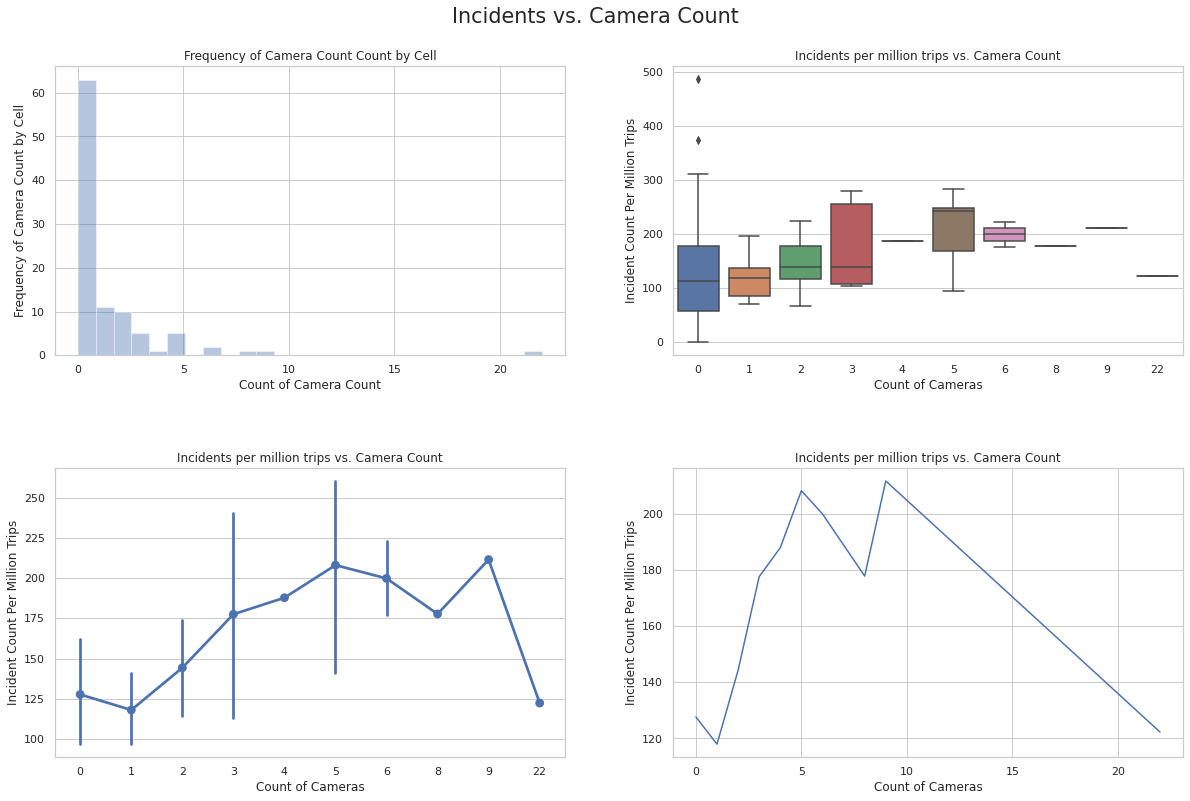

In [29]:
df =  ctrl.get_frame('cells')
target_text = 'Camera Count'
target_col = 'camera_count'
responding_col = 'inc_per_mil_vol'
x_label = 'Count of Cameras'
y_label = 'Incident Count Per Million Trips'
title = 'Incidents Per Million Trips vs. Camera Count'
binned = False

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents vs. Signals

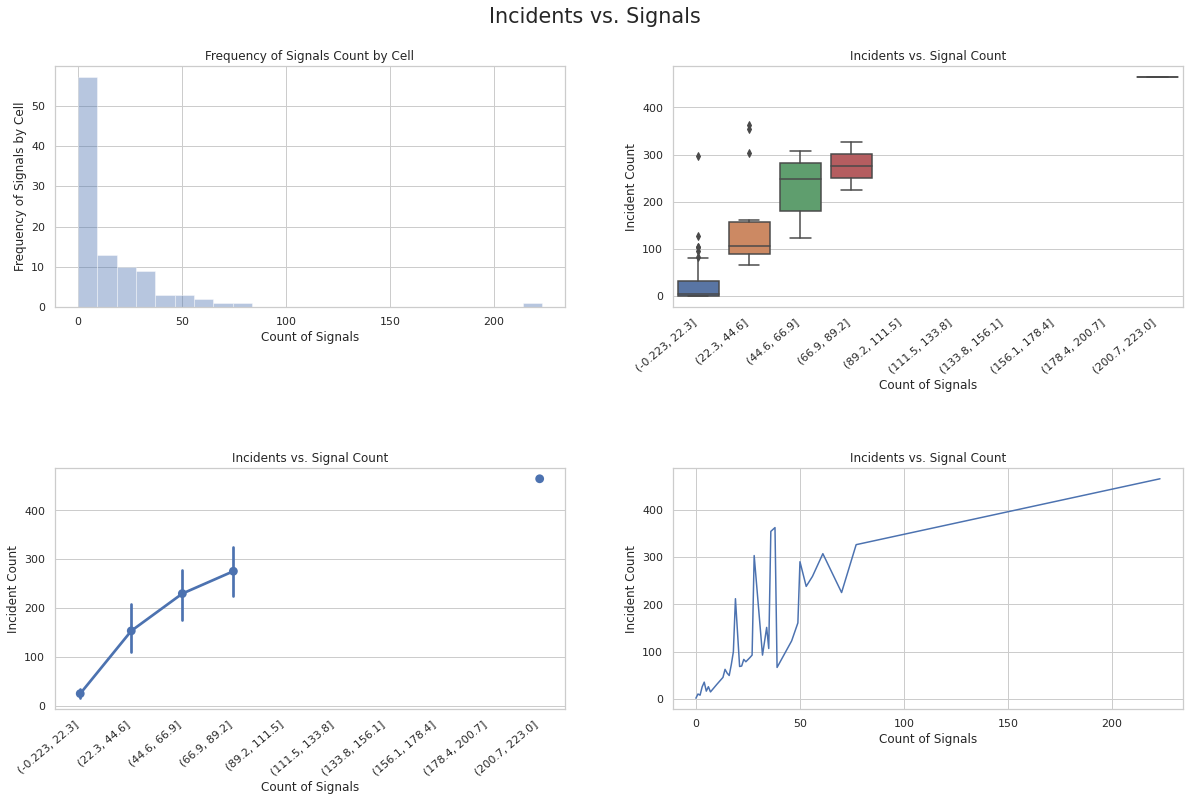

In [30]:
df =  ctrl.get_frame('cells')
target_text = 'Signals'
target_col = 'signal_count'
responding_col = 'incident_count'
x_label = 'Count of Signals'
y_label = 'Incident Count'
title = 'Incidents vs. Signal Count'
binned = True
bin_col = 'signal_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents per million trips vs. Signals

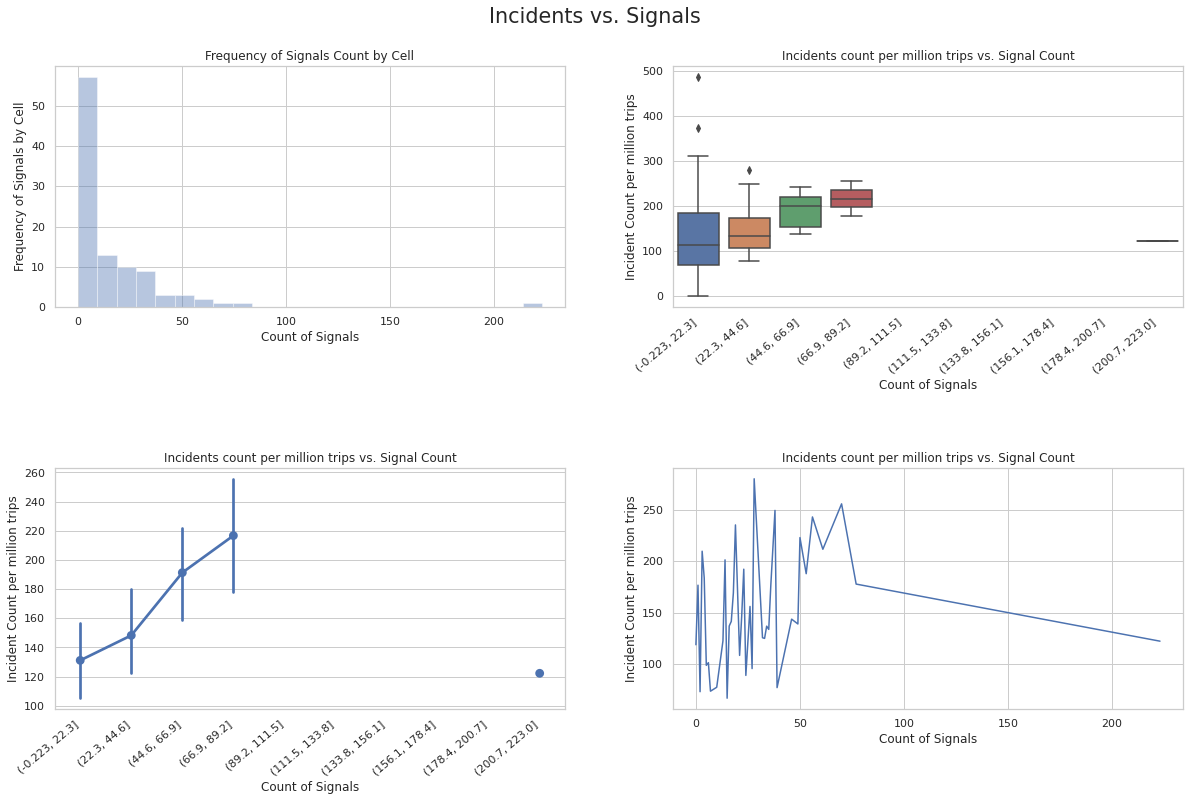

In [31]:
df =  ctrl.get_frame('cells')
target_text = 'Signals'
target_col = 'signal_count'
responding_col = 'inc_per_mil_vol'
x_label = 'Count of Signals'
y_label = 'Incident Count Per Million Trips'
title = 'Incidents Count Per Million Trips vs. Signal Count'
binned = True
bin_col = 'signal_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents vs. Signs

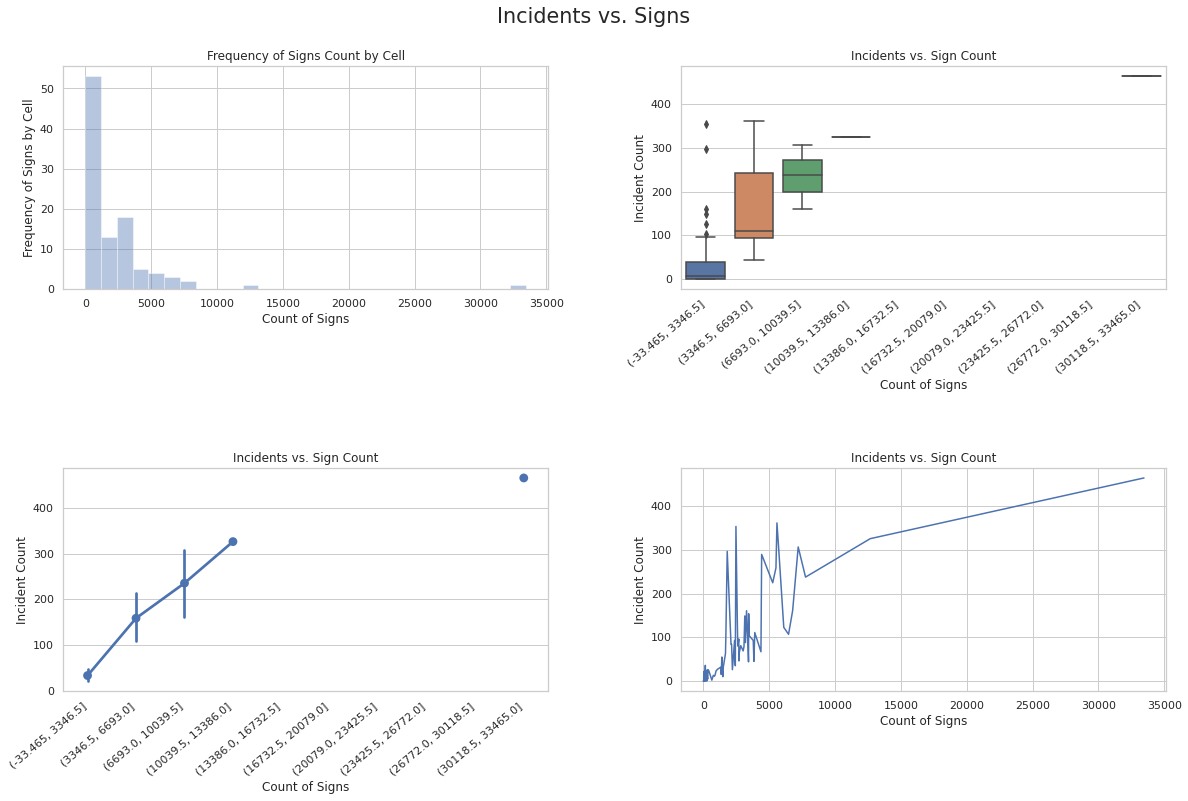

In [18]:
df =  ctrl.get_frame('cells')
target_text = 'Signs'
target_col = 'sign_count'
responding_col = 'incident_count'
x_label = 'Count of Signs'
y_label = 'Incident Count'
title = 'Incidents vs. Sign Count'
binned = True
bin_col = 'sign_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incident Count Per Million Trip vs. Signs

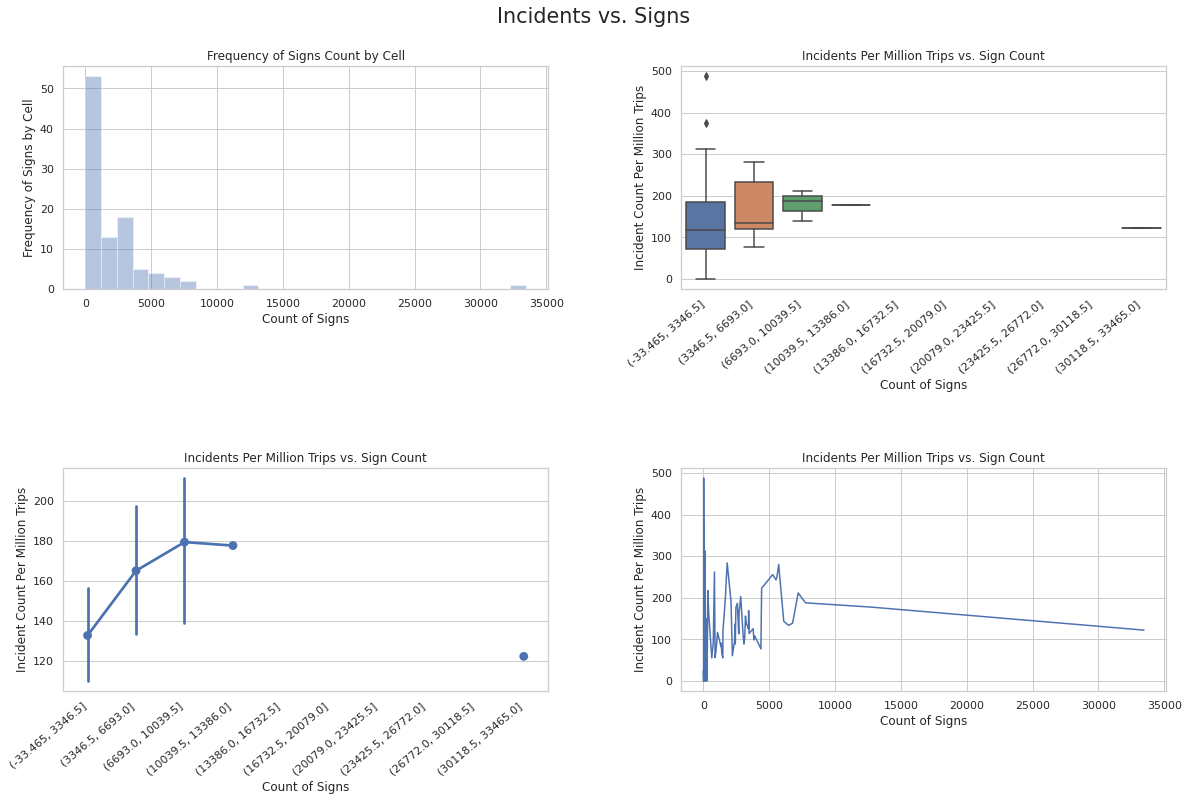

In [34]:
df =  ctrl.get_frame('cells')
target_text = 'Signs'
target_col = 'sign_count'
responding_col = 'inc_per_mil_vol'
x_label = 'Count of Signs'
y_label = 'Incident Count Per Million Trips'
title = 'Incidents Per Million Trips vs. Sign Count'
binned = True
bin_col = 'sign_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents vs. Hourly Temperature

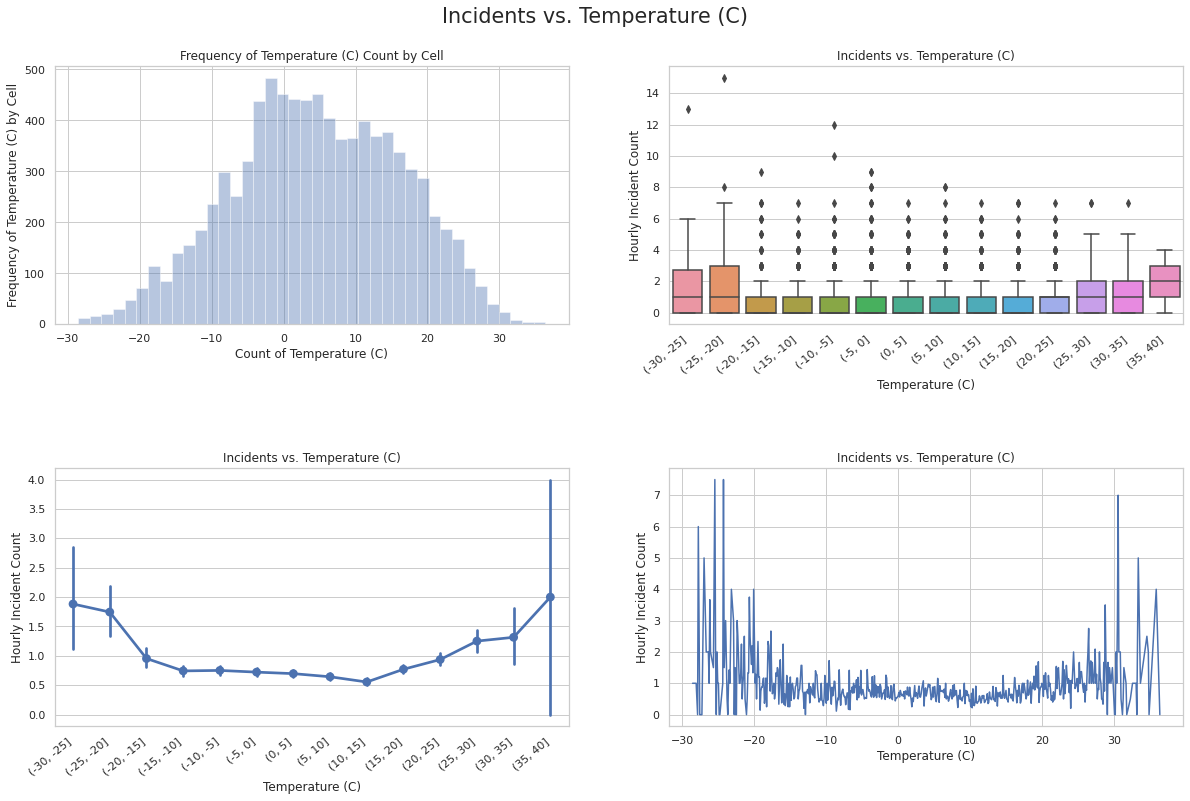

In [19]:
df = ctrl.get_frame('hourly')
target_text = 'Temperature (C)'
target_col = 'Temp (C)'
responding_col = 'incidents'
x_label = 'Temperature (C)'
y_label = 'Hourly Incident Count'
title = 'Incidents vs. Temperature (C)'
binned = True
bin_col = 'temp_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents vs. Daily Average Temperature 

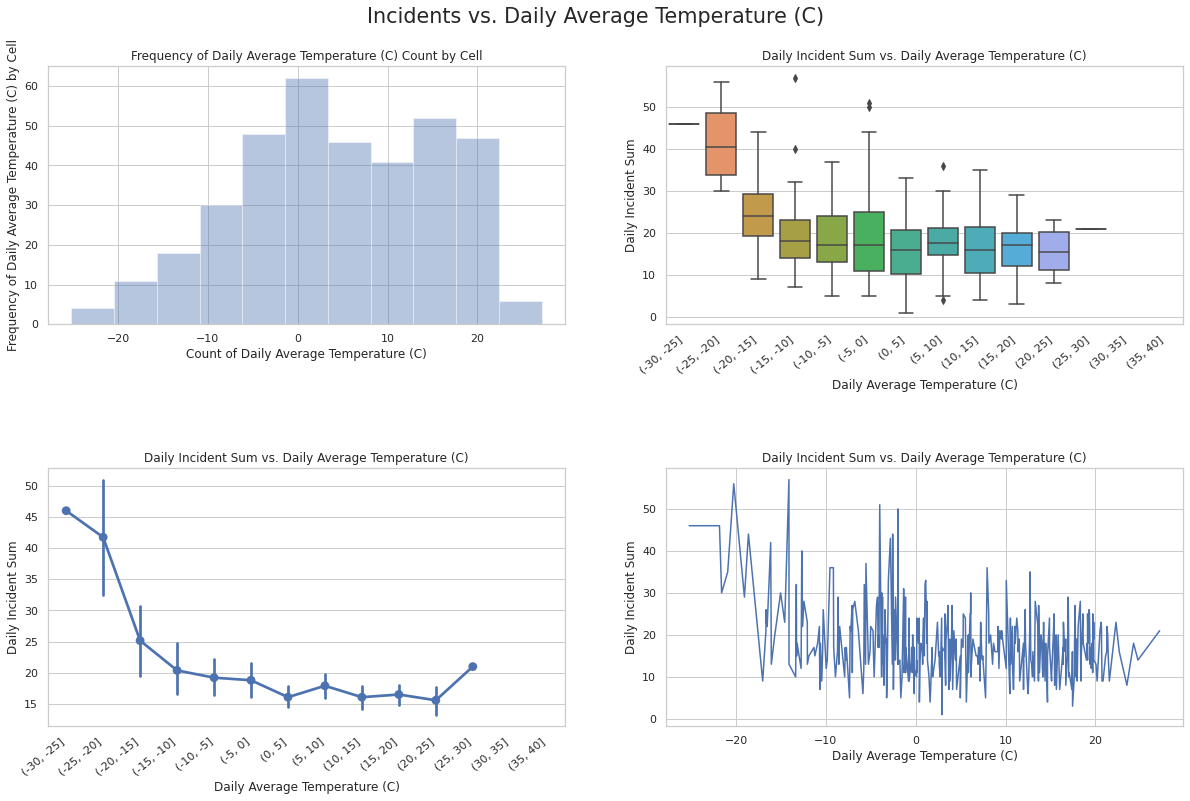

In [20]:
df = ctrl.get_frame('daily')
target_text = 'Daily Average Temperature (C)'
target_col = 'avg_daily_temp'
responding_col = 'sum_daily_incidents'
x_label = 'Daily Average Temperature (C)'
y_label = 'Daily Incident Sum'
title = 'Daily Incident Sum vs. Daily Average Temperature (C)'
binned = True
bin_col = 'temp_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents vs. Hourly Visibility

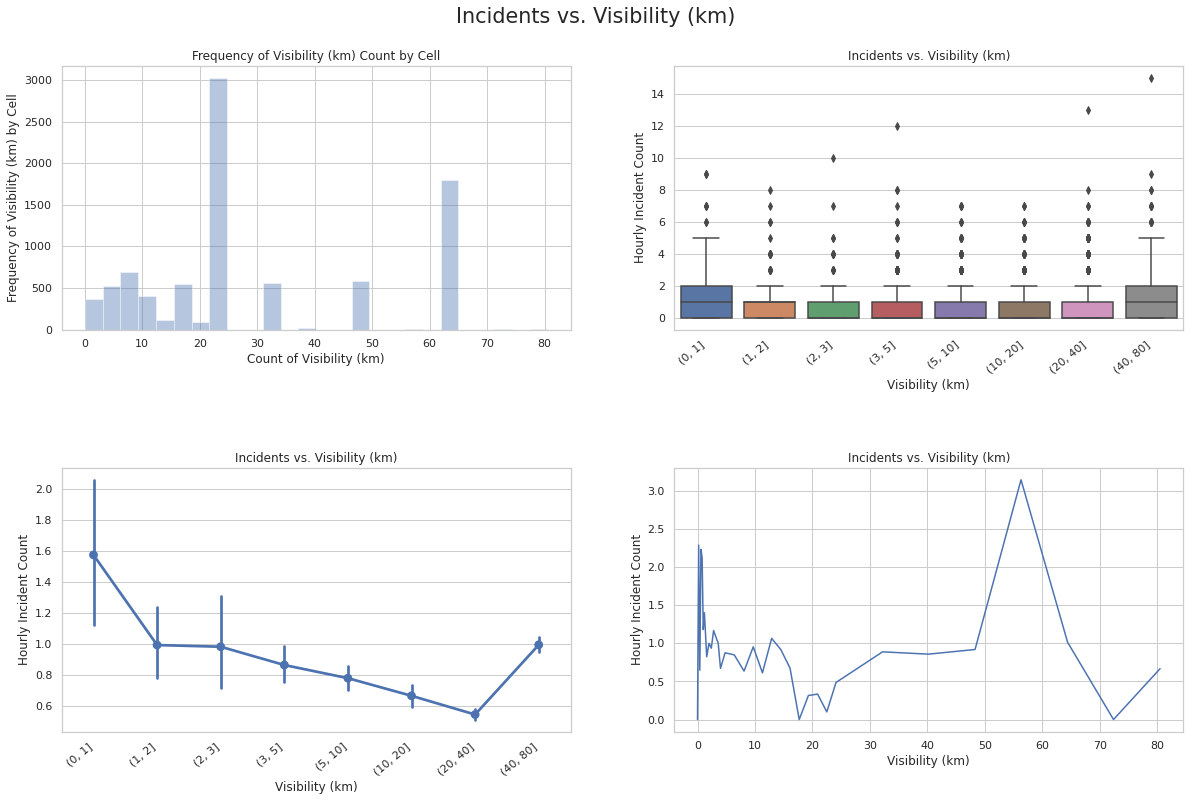

In [21]:
df = ctrl.get_frame('hourly')
target_text = 'Visibility (km)'
target_col = 'Visibility (km)'
responding_col = 'incidents'
x_label = 'Visibility (km)'
y_label = 'Hourly Incident Count'
title = 'Incidents vs. Visibility (km)'
binned = True
bin_col = 'vis_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Incidents vs. Daily Average Visibility


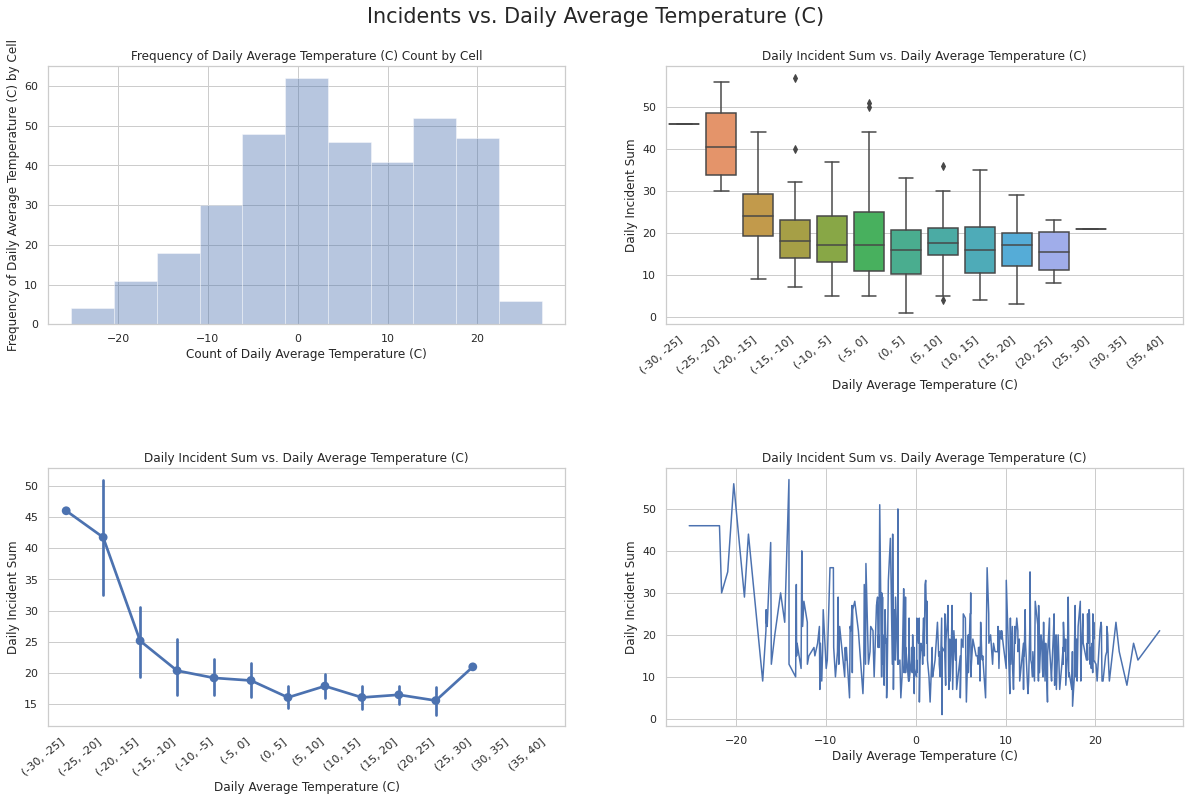

In [22]:
df = ctrl.get_frame('daily')
target_text = 'Daily Average Temperature (C)'
target_col = 'avg_daily_temp'
responding_col = 'sum_daily_incidents'
x_label = 'Daily Average Temperature (C)'
y_label = 'Daily Incident Sum'
title = 'Daily Incident Sum vs. Daily Average Temperature (C)'
binned = True
bin_col = 'temp_bins'

fig = ctrl.get_super_plot(df, target_text, target_col, responding_col, x_label, y_label, title, binned, bin_col)
fig.show()

# Melt Freeze Analysis

There were 143 melt-freeze cycles in 2018!


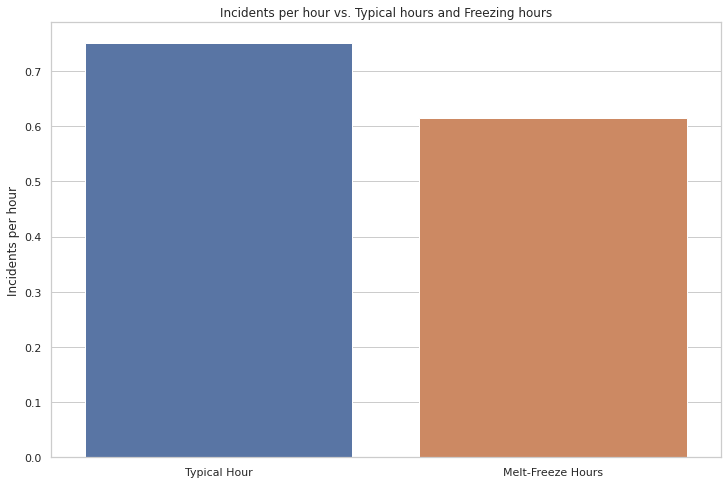

In [23]:
'''
Cell calculates the number of hours during the year where a "melt-freeze' cycle occured per ctrl.melt_freeze(). Intent of this analysis to is determine if melt-freeze cycles correlate with an increase in incidents. 
'''
temps = ctrl.get_frame('hourly')['Temp (C)']

#See ctrl.melt_freeze() for a full description of below function. In this case, returns a boolean mask used to filter the hourly dataframe for all hours with 8 hours of freeze event. 
melt_freeze = ctrl.melt_freeze(temps, 0, 8)

freeze_temps = ctrl.get_frame('hourly')[melt_freeze]

inc_per_hour_freeze = freeze_temps['incidents'].sum() / freeze_temps['incidents'].size

inc_per_hour_typ = ctrl.get_frame('hourly')['incidents'].sum() / ctrl.get_frame('hourly')['incidents'].size

#dataframe simply used to plot below, suprising results. May be due to people driving more slowly during a freeze or less traffic if freezes typical occur at nigth during low traffic volumes. 
data = pd.DataFrame({"Incidents per hour": [inc_per_hour_typ, inc_per_hour_freeze], 'Total Incidents' : [ctrl.get_frame('hourly')['incidents'].sum(),freeze_temps['incidents'].sum()], "Number of Hours" : [ctrl.get_frame('hourly')['incidents'].size,freeze_temps['incidents'].size]})

data.rename(index={0: 'Typical Hour', 1: 'Melt-Freeze Hours'}, inplace=True)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8), ) 
sns.barplot(x=data.index, y=data['Incidents per hour'])
ax.set_title('Incidents per hour vs. Typical hours and Freezing hours')
plt.savefig(f'./plots/meltfreeze.png')
fig.show()
